In [1]:
from typing import Union, List
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyblock
from scipy.optimize import minimize

In [2]:
def walk(atoms: int,
         timesteps: np.ndarray,
         jump_size: int = 1,
         seed: np.random.mtrand.RandomState = np.random.RandomState()) -> np.ndarray:
    """
    Perform a random walk.

    :param atoms: number of atoms
    :param timesteps: the timestep values
    :param jump_size: size of jump
    :param seed: random seed source
    :return: cumulative sum of steps for walk
    """
    possible_moves = np.zeros((6, 3))
    j = 0
    for i in range(0, 6, 2):
        possible_moves[i, j] = jump_size
        possible_moves[i + 1, j] = -jump_size
        j += 1
    choices = seed.choice(len(range(len(possible_moves))), size=(atoms, len(timesteps)))
    steps = np.zeros((atoms, len(timesteps), 3))
    for i in range(steps.shape[0]):
        for j in range(steps.shape[1]):
            steps[i, j] = possible_moves[choices[i, j]]
    cum_steps = np.cumsum(steps, axis=1)
    return cum_steps

In [3]:
# Copyright (c) Andrew R. McCluskey
# Distributed under the terms of the MIT License
# author: Andrew R. McCluskey (arm61)

import numpy as np
from tqdm import tqdm
#from random_walk import walk

jump = 1
atoms = 124
length = 128
size = 1000

var_est = np.zeros((length,size))
var_pyb = np.zeros((length,size))
error_prop = np.zeros((length,size))
var_norm = np.zeros((length,size))


timestep = np.arange(1, length + 1, 1, dtype=int)
k = np.zeros((size, timestep.size))
dx_mean = np.zeros((length,size))
exp_mean = np.zeros((length,size))
exp_std = np.zeros((length,size))



for seed in tqdm(range(size)):

    exp_x_store = []
    dx_store = []
    rng = np.random.RandomState(seed)
    cum_steps = walk(atoms, timestep, seed=rng, jump_size=jump)

    for i, n in enumerate(timestep):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                               np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                              axis=1)
        
        #d_x = np.tensordot(np.array((0.4,0.8,0.6)),disp, axes=[[0],[2]]) #np.abs(disp[:,:,0])
        d_x = np.dot(disp, np.array((1,1,1)))
        exp_x = np.exp(1j*d_x)



        var_est[i,seed] = np.var(d_x)/(timestep[-1]/timestep[i]*atoms)



        reblock = pyblock.blocking.reblock(np.real(exp_x.flatten()))
        opt_block = pyblock.blocking.find_optimal_block(exp_x.flatten().size, reblock)
        var_pyb[i,seed] =  reblock[opt_block[0]].std_err**2

        var_norm[i,seed] = np.var(np.real(exp_x.flatten()))/(timestep[-1]/timestep[i]*atoms)
        
        dfdx = np.abs(1j*np.exp(1j*d_x.flatten())) # Problem is that this is just 1 
        dfdx_m = np.mean(dfdx) # does this make sense?????
        error_prop[i,seed] = var_pyb[i,seed]*dfdx_m


        exp_x_store.append(exp_x)
        dx_store.append(d_x)
        
        
    for x in range(length):
        dx_mean[x,seed] = np.mean(dx_store[x],axis = (0,1))
        exp_mean[x,seed] = np.mean(exp_x_store[x],axis = (0,1))
        exp_std[x,seed] = np.std(exp_x_store[x],axis = (0,1))


var_num = dx_mean.var(axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_2441/2908047776.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  exp_mean[x,seed] = np.mean(exp_x_store[x],axis = (0,1))
100%|██████████| 1000/1000 [01:35<00:00, 10.52it/s]


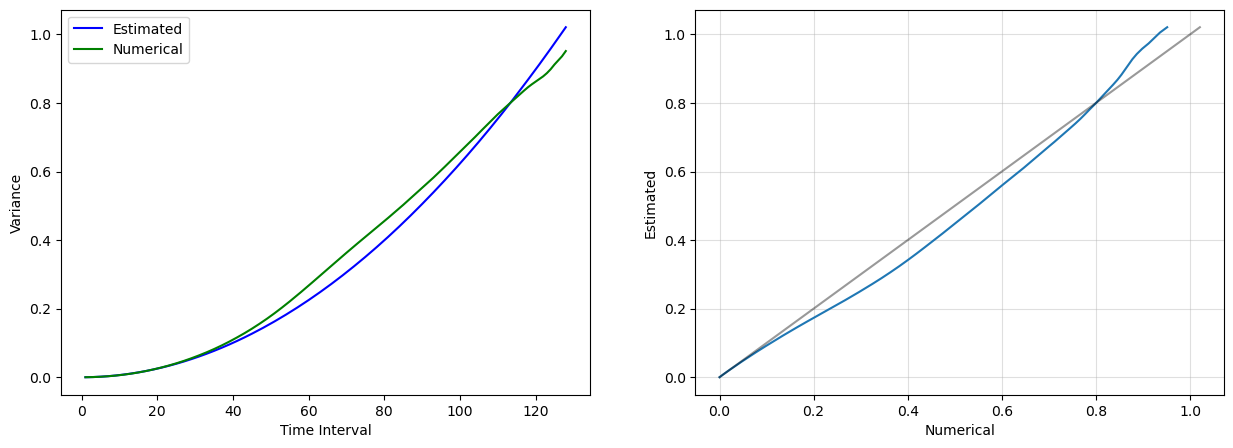

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(timestep,np.mean(var_est,axis = 1), color = 'blue')
#ax[0].plot(timestep,np.mean(var_pyb,axis=1), color = 'orange')
ax[0].plot(timestep,var_num, color = 'green')
ax[0].legend(['Estimated', 'Numerical'])
ax[0].set_xlabel('Time Interval')
ax[0].set_ylabel('Variance')

# ax[1].plot(timestep,std_num/np.mean(std_est,axis = 1))
# ax[1].grid(alpha = 0.4)

ax[1].plot(var_num,np.mean(var_est,axis = 1))
#ax[1].plot(var_num,np.mean(var_pyb,axis = 1))
ax[1].set_xlabel('Numerical')
ax[1].set_ylabel('Estimated')
ax[1].plot(np.linspace(0,np.mean(var_est,axis = 1).max(),100),np.linspace(0,np.mean(var_est,axis = 1).max(),100), c = 'k', alpha = 0.4)
ax[1].grid(alpha = 0.4)

plt.show()

In [5]:
np.cov(exp_mean).shape

(128, 128)

In [6]:
np.std(x)

0.0

In [7]:
x = np.real(exp_x.flatten())



for i in range(6):

    if len(x) % 2 != 0:
        x = x[:-1]

    print(f'block: {i}')
    if i > 0:
        x = x.reshape(-1, 2).mean(axis=1)

    n_samp = len(x)
    print(f'n_samps: {n_samp}')

    std_err = np.sqrt(np.cov(x)/(n_samp))
    print(f'std_err:  {std_err}')

    std_err_err = std_err / np.sqrt(2*(n_samp-1))
    print(f'std_err_err: {std_err_err}')

    if i==0:
        first_err = std_err

    print(len(x)**3)
    print(2**(3*(i)))
    print(2 * n_samp * (std_err / first_err)**4)
    print(f'is optimum: {2**(3*(i)) > 2 * n_samp * (std_err / first_err)**4}')
    print(f'is optimum: {len(x)**3 > 2 * n_samp * (std_err / first_err)**4}')



block: 0
n_samps: 124
std_err:  0.06319167843916092
std_err_err: 0.004028954263219564
1906624
1
248.0
is optimum: False
is optimum: True
block: 1
n_samps: 62
std_err:  0.06451956830108446
std_err_err: 0.0058413272504799114
238328
8
134.7559447835771
is optimum: False
is optimum: True
block: 2
n_samps: 31
std_err:  0.05624777271308936
std_err_err: 0.007261556232635169
29791
64
38.920055080179665
is optimum: True
is optimum: True
block: 3
n_samps: 15
std_err:  0.05391298334189551
std_err_err: 0.01018859616858739
3375
512
15.894803020493525
is optimum: True
is optimum: True
block: 4
n_samps: 7
std_err:  0.02900546202717603
std_err_err: 0.008373155654679776
343
4096
0.6214520474343246
is optimum: True
is optimum: True
block: 5
n_samps: 3
std_err:  0.04888125773970862
std_err_err: 0.02444062886985431
27
32768
2.1482319675953105
is optimum: True
is optimum: True


In [8]:
np.std(exp_x.flatten())

0.994345462801129

In [9]:
2 * 62 * std_err / np.var(exp_x.flatten())**4

6.342576089971931

In [10]:
reblock[opt_block[0]].std_err

array(0.05391298)

In [11]:
pyblock.blocking.find_optimal_block(exp_x.flatten().size, reblock)

[3]

In [12]:
  for iblock, data_len, mean, cov, std_err, std_err_err in reversed(pyblock.blocking.reblock(np.real(exp_x.flatten()))):
    print(iblock)
    print()

5

4

3

2

1

0



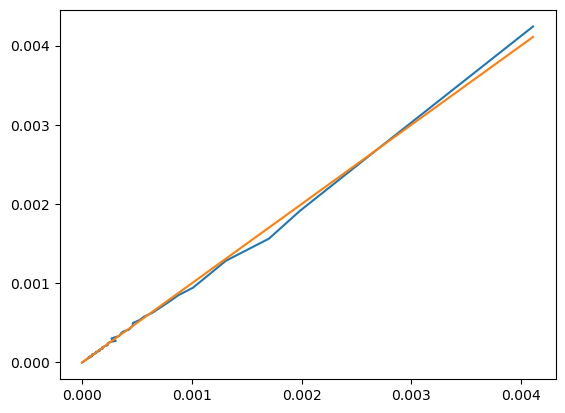

In [13]:

plt.plot(np.var(exp_mean,axis=1),np.mean(var_pyb,axis = 1))
plt.plot(np.var(exp_mean,axis=1),np.var(exp_mean,axis=1))
#plt.plot(np.var(exp_mean,axis=1),np.mean(var_norm,axis=1))

/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_2441/912554453.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(timestep, np.var(exp_mean,axis=1)/np.mean(var_pyb,axis = 1))


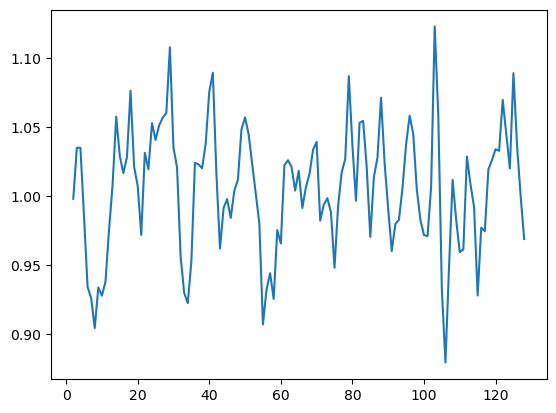

In [14]:
plt.plot(timestep, np.var(exp_mean,axis=1)/np.mean(var_pyb,axis = 1))

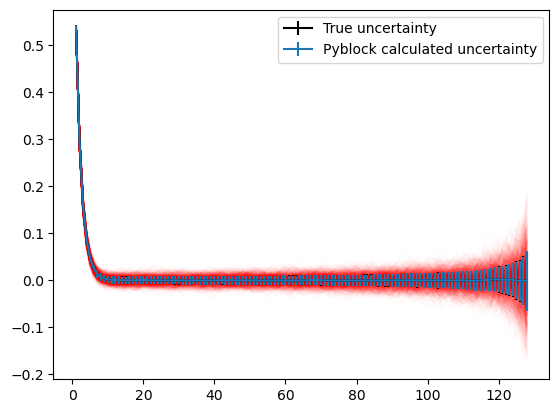

In [15]:
plt.plot(timestep,exp_mean, color = 'red',alpha = 0.01)
#plt.errorbar(timestep,np.mean(exp_mean,axis=1),np.mean(error_prop,axis=1), color = 'blue', label = 'Propogated error',alpha = 0.5)
plt.errorbar(timestep,np.mean(exp_mean,axis=1),np.std(exp_mean,axis=1), color = 'black', label = 'True uncertainty')
plt.errorbar(timestep,np.mean(exp_mean,axis=1),np.mean(np.sqrt(var_pyb),axis=1), label = 'Pyblock calculated uncertainty')
plt.legend()

